# Pylops - Least squares migration

### Author: M.Ravasi

In this notebook I will show you how to perform least-squares migration with a Kirchoff modelling operator.

The modelling is simply expressed by the following equation

$$ d(s, r, t) = w(t) * \int_V G(x,s, t) G(r,x, t) r(x,z) dx dz$$

where $r(x, z)$ is our model and it represents the reflectivity at every location in the subsurface, $G(r,x, t)$ and $G(x,s, t)$ are the Green's functions from source to subsurface to receiver and finally $w$ is the wavelet.

In a matrix for

$$ \mathbf{d} = \mathbf{W} \mathbf{G} \mathbf{r}$$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.lsm import _traveltime_table, Demigration, LSM

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

## 2D layered in homogenous velocity

Lets' create a model and geometry

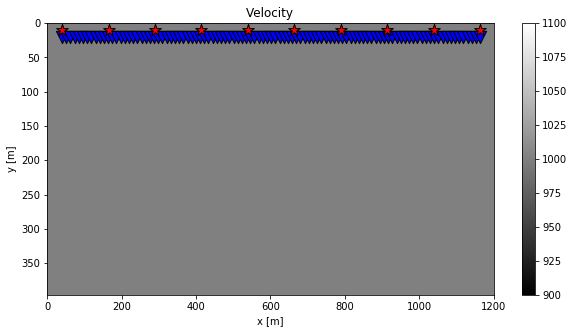

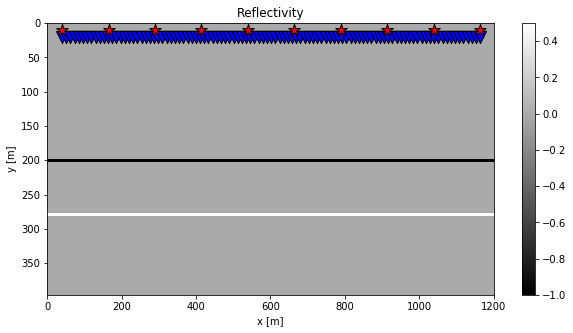

In [2]:
# Velocity Model
nx, nz = 301, 100
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz
v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

# Reflectivity Model
refl = np.zeros((nx, nz))
#refl[:, 20] = 1
refl[:, 50] = -1
refl[:, 70] = 0.5

# Receivers
nr = 101
rx = np.linspace(10*dx, (nx-10)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 10
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.xlim(x[0], x[-1]);

Compute traveltimes for homogenous medium

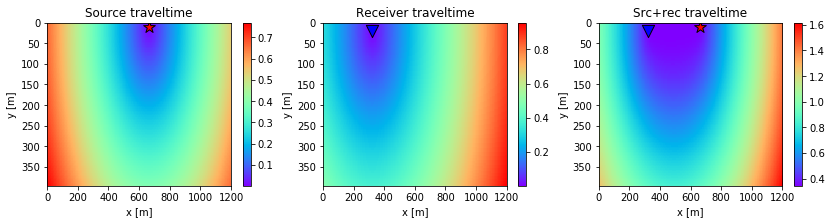

In [3]:
trav, trav_srcs, trav_recs = _traveltime_table(z, x, sources, recs, v0, mode='analytic')

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
im = axs[0].imshow(trav_srcs[:, ns//2].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(trav_recs[:, nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(trav[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_ylabel('y [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[2]);

Let's also try to compute the gradients of the contours

trav_middle = trav[:, nr//4].reshape((nx, nz)).T
trav_grad = np.gradient(trav_middle)


plt.figure()
plt.imshow(trav_middle)

plt.figure()
plt.imshow(trav_grad[0])
plt.figure()
plt.imshow(trav_grad[1])

fig, ax = plt.subplots()
q = ax.quiver(trav_grad[1], trav_grad[0],
              headlength=100)

Let's do the same using an eikonal solver

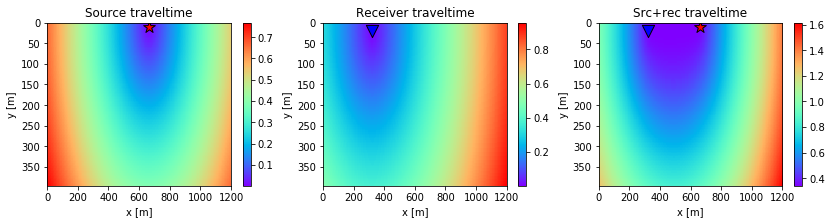

In [4]:
trav_eik, trav_srcs_eik, trav_recs_eik = _traveltime_table(z, x, sources, recs, vel, mode='eikonal')

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
im = axs[0].imshow(trav_srcs_eik[:, ns//2].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(trav_recs_eik[:, nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(trav_eik[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_ylabel('y [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[2]);

Finally we model the data and invert it

In [5]:
nt = 651
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

itrav = (np.round(trav/dt)).astype(np.int32)
travd = trav - itrav
itrav = itrav.reshape(nx, nz, ns*nr)
travd = travd.reshape(nx, nz, ns*nr)

In [6]:
lsm = LSM(z, x, t, sources, recs, v0, wav, wavc,
                     mode='analytic')

d = lsm.Demop * refl.ravel()
d = d.reshape(ns, nr, nt)

madj = lsm.Demop.H * d.ravel()
madj = madj.reshape(nx, nz)

minv = lsm.solve(d.ravel(), solver=lsqr, **dict(iter_lim=100, show=True))
minv = minv.reshape(nx, nz)

minv_sparse = lsm.solve(d.ravel(), solver=FISTA, **dict(eps=5e6, niter=200, show=True))
minv_sparse = minv_sparse.reshape(nx, nz)

# demigration
dadj = lsm.Demop * madj.ravel()
dadj = dadj.reshape(ns, nr, nt)

dinv = lsm.Demop * minv.ravel()
dinv = dinv.reshape(ns, nr, nt)

dinv_sparse = lsm.Demop * minv_sparse.ravel()
dinv_sparse = dinv_sparse.reshape(ns, nr, nt)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has   657510 rows  and    30100 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.767e+05  2.767e+05    1.0e+00  2.2e-01
     1  6.72828e-04   1.730e+05  1.730e+05    6.3e-01  6.8e-01   7.8e+04  1.0e+00
     2 -9.44638e-04   1.529e+05  1.529e+05    5.5e-01  3.5e-01   1.4e+05  2.3e+00
     3 -3.00402e-03   1.376e+05  1.376e+05    5.0e-01  2.2e-01   2.1e+05  4.2e+00
     4 -6.82480e-03   1.065e+05  1.065e+05    3.8e-01  1.2e-01   2.4e+05  7.0e+00
     5 -3.09745e-03   9.007e+04  9.007e+04    3.3e-01  1.1e-01   2.5e+05  9.1e+00
     6 -5.12281e-03   7.994e+04  7.994e+04    2.9e-01  9.6e-02   2.6e+05  1.1e+01
     7 -7.94787e-04   7.265e+04  7.265e+04    2.6e-01  9.1e-02   2.7e+05  1.4e+01
     8 -5.44967e-03   6.797e

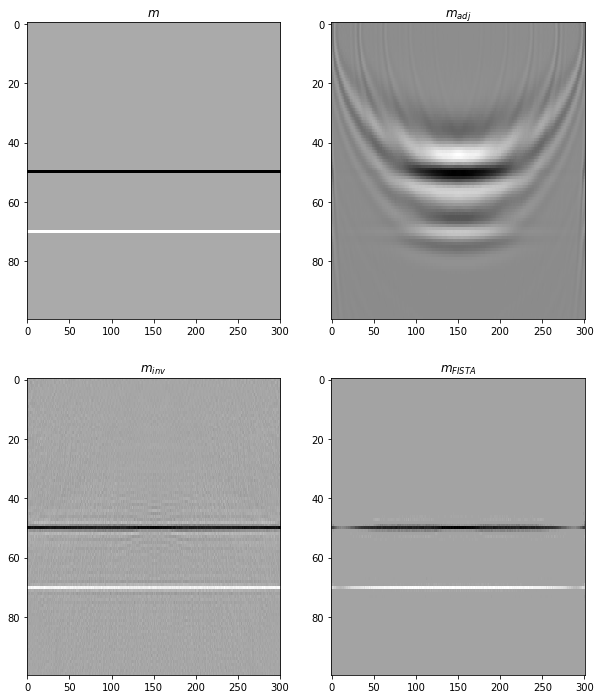

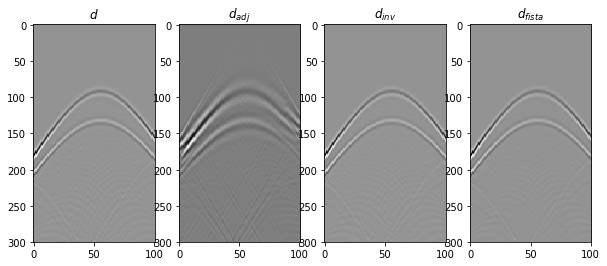

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10, 12))
axs[0][0].imshow(refl.T, cmap='gray')
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(madj.T, cmap='gray')
axs[0][1].set_title(r'$m_{adj}$')
axs[0][1].axis('tight')
axs[1][0].imshow(minv.T, cmap='gray')
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{inv}$');
axs[1][1].imshow(minv_sparse.T, cmap='gray')
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{FISTA}$');

fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].imshow(d[ns//2, :, :300].T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(dadj[ns//2, :, :300].T, cmap='gray')
axs[1].set_title(r'$d_{adj}$')
axs[1].axis('tight')
axs[2].imshow(dinv[ns//2, :, :300].T, cmap='gray')
axs[2].set_title(r'$d_{inv}$')
axs[2].axis('tight')
axs[3].imshow(dinv_sparse[ns//2, :, :300].T, cmap='gray')
axs[3].set_title(r'$d_{fista}$')
axs[3].axis('tight');

## 2D layered in gradient velocity

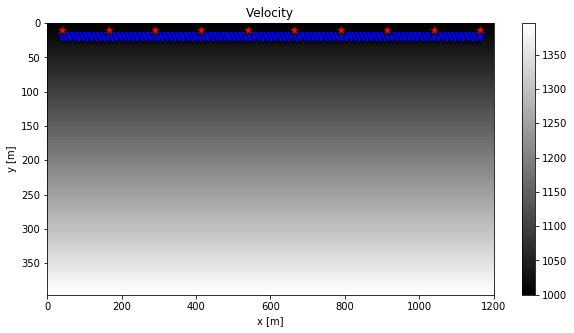

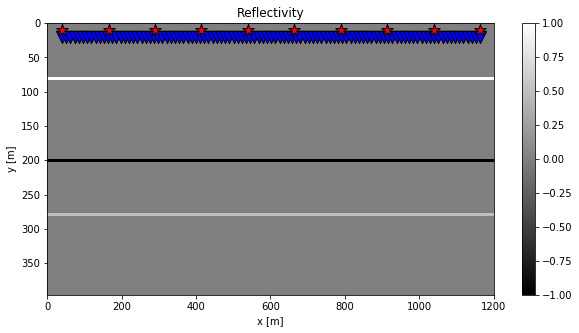

In [8]:
# Velocity Model
nx, nz = 301, 100
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz
v0 = 1000 # initial velocity
kv = 1 # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

# Reflectivity Model
refl = np.zeros((nx, nz))
refl[:, 20] = 1
refl[:, 50] = -1
refl[:, 70] = 0.5

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.xlim(x[0], x[-1]);

Compute traveltimes with eikonal

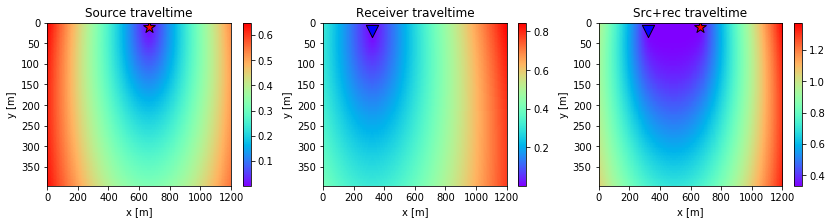

In [9]:
X, Z = np.meshgrid(x, z, indexing='ij')
X, Z = X.flatten(), Z.flatten()

trav, trav_srcs, trav_recs = _traveltime_table(z, x, sources, recs, vel, mode='eikonal')

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
im = axs[0].imshow(trav_srcs[:, ns//2].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(trav_recs[:, nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(trav[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_ylabel('y [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[2]);

Create data and invert model

In [10]:
nt = 601
dt = 0.004
t = np.arange(nt)*dt

itrav = (np.round(trav/dt)).astype(np.int32)
travd = trav - itrav
itrav = itrav.reshape(nx, nz, ns*nr)
travd = travd.reshape(nx, nz, ns*nr)

Sop = Spread(dims=(nx, nz), dimsd=(ns*nr, nt), table=itrav, dtable=travd, engine='numba')
wav, wavt, wavc = ricker(t[:41], f0=20)
Cop = Convolve1D(ns*nr*nt, h=wav, offset=wavc, dims=(ns*nr, nt), dir=1)

LSMop = Cop*Sop
LSMop = LinearOperator(LSMop, explicit=False)
%timeit -n 3 -r 1 LSMop * refl.ravel()
d1 = LSMop * refl.ravel()

lsm = LSM(z, x, t, sources, recs, vel, wav, wavc, mode='eikonal')
%timeit -n 3 -r 1 LSMop * refl.ravel()

d = lsm.Demop * refl.ravel()
print(np.allclose(d, d1))
d = d.reshape(ns, nr, nt)

madj = lsm.Demop.H * d.ravel()
madj = madj.reshape(nx, nz)

minv = lsm.solve(d.ravel(), solver=lsqr, **dict(iter_lim=50, show=2))
minv = minv.reshape(nx, nz)

minv_sparse = lsm.solve(d.ravel(), solver=FISTA, **dict(eps=1e6, niter=200, show=True))
minv_sparse = minv_sparse.reshape(nx, nz)

# demigration
dadj = LSMop * madj.ravel()
dadj = dadj.reshape(ns, nr, nt)

dinv = LSMop * minv.ravel()
dinv = dinv.reshape(ns, nr, nt)

dinv_sparse = LSMop * minv_sparse.ravel()
dinv_sparse = dinv_sparse.reshape(ns, nr, nt)

332 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)
504 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)
True
 
LSQR            Least-squares solution of  Ax = b
The matrix A has   607010 rows  and    30100 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.205e+05  6.205e+05    1.0e+00  2.4e-01
     1  6.67312e-05   2.761e+05  2.761e+05    4.4e-01  4.1e-01   1.7e+05  1.0e+00
     2  4.39970e-04   1.838e+05  1.838e+05    3.0e-01  1.9e-01   2.0e+05  2.4e+00
     3  1.97980e-05   1.564e+05  1.564e+05    2.5e-01  2.2e-01   2.1e+05  4.1e+00
     4 -5.97639e-04   1.172e+05  1.172e+05    1.9e-01  1.2e-01   2.4e+05  6.9e+00
     5  9.68883e-05   1.023e+05  1.023e+05    1.6e-01  1.0e-01   2.4e+05  8.8e+00
     6  2.49913e-03   9.373e+04  9.373e+04    1.5e-01  9.

(-0.5, 100.5, 299.5, -0.5)

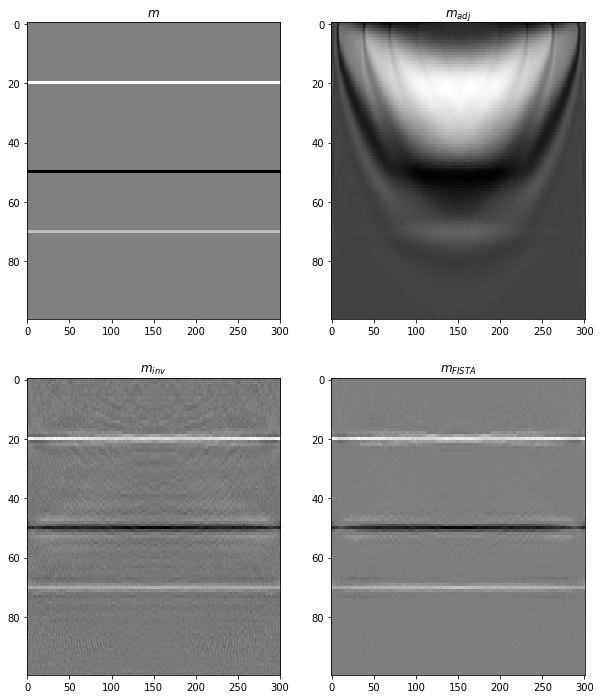

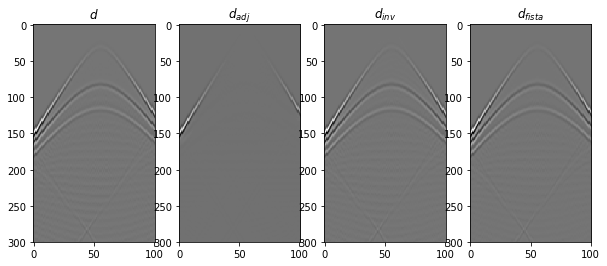

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 12))
axs[0][0].imshow(refl.T, cmap='gray')
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(madj.T, cmap='gray')
axs[0][1].set_title(r'$m_{adj}$')
axs[0][1].axis('tight')
axs[1][0].imshow(minv.T, cmap='gray')
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{inv}$');
axs[1][1].imshow(minv_sparse.T, cmap='gray')
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{FISTA}$');

fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].imshow(d[ns//2, :, :300].T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(dadj[ns//2, :, :300].T, cmap='gray')
axs[1].set_title(r'$d_{adj}$')
axs[1].axis('tight')
axs[2].imshow(dinv[ns//2, :, :300].T, cmap='gray')
axs[2].set_title(r'$d_{inv}$')
axs[2].axis('tight')
axs[3].imshow(dinv_sparse[ns//2, :, :300].T, cmap='gray')
axs[3].set_title(r'$d_{fista}$')
axs[3].axis('tight')

Finally we try to invert for the velocity model itself

$$ \mathbf{d} = \mathbf{W} \mathbf{G}  \mathbf{D} \mathbf{m}$$

In [12]:
# Velocity Model
v0 = 1600 # initial velocity
vel = v0*np.ones((nx,nz))
vel[:, 40:50] = 1800
vel[:, 50:80] = 2000
vel[:, 80:] = 2500

# Smooth velocity
nsmooth=20
velback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel, axis=0)
for _ in range(5):
    velback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, velback, axis=1)

# Traveltime
nt = 401
dt = 0.004
t = np.arange(nt)*dt
trav, trav_srcs, trav_recs = _traveltime_table(z, x, sources, recs, velback, mode='eikonal')

itrav = (np.round(trav/dt)).astype(np.int32)
travd = trav - itrav
itrav = itrav.reshape(nx, nz, ns*nr)
travd = travd.reshape(nx, nz, ns*nr)

# Modelling
Sop = Spread(dims=(nx, nz), dimsd=(ns*nr, nt), table=itrav, dtable=travd, engine='numba')
dottest(Sop, ns*nr*nt, nx*nz, verb=True)

wav, wavt, wavc = ricker(t[:41], f0=20)
Cop = Convolve1D(ns*nr*nt, h=wav, offset=wavc, dims=(ns*nr, nt), dir=1)
Dop = FirstDerivative(nx*nz, dims=(nx, nz), dir=1)
LSMop = Cop*Sop*Dop
LSMop = LinearOperator(LSMop, explicit=False)

d = LSMop * np.log(vel).ravel()
d = d.reshape(ns, nr, nt)
dback = LSMop * np.log(velback).ravel()
dback = dback.reshape(ns, nr, nt)

madj = (Cop*Sop).H * d.ravel()
madj = madj.reshape(nx, nz)

# Regularized inversion
Regop = SecondDerivative(nx*nz, (nx, nz), dir=0)
minv = RegularizedInversion(LSMop, [Regop], d.ravel(),
                            x0=np.log(velback).ravel(),
                            epsRs=[1e5], returninfo=False,
                            **dict(iter_lim=200, show=True))
minv = np.exp(minv.reshape((nx, nz)))

# demigration
dadj = LSMop * madj.ravel()
dadj = dadj.reshape(ns, nr, nt)

dinv = LSMop * minv.ravel()
dinv = dinv.reshape(ns, nr, nt)

Dot test passed, v^T(Opu)=186081.657058 - u^T(Op^Tv)=186081.657058
 
LSQR            Least-squares solution of  Ax = b
The matrix A has   435110 rows  and    30100 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      200
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   4.334e+04  4.334e+04    1.0e+00  2.4e-01
     1 -2.25080e-04   3.840e+04  3.840e+04    8.9e-01  5.5e+00   2.2e+04  1.0e+00
     2 -1.59330e-04   3.418e+04  3.418e+04    7.9e-01  1.9e-01   3.6e+05  2.1e+01
     3  2.24350e-04   3.300e+04  3.300e+04    7.6e-01  9.0e-02   4.6e+05  2.9e+01
     4  6.25216e-04   3.247e+04  3.247e+04    7.5e-01  5.9e-02   5.4e+05  3.5e+01
     5  1.05885e-03   3.211e+04  3.211e+04    7.4e-01  4.7e-02   6.0e+05  4.0e+01
     6  1.69817e-03   3.181e+04  3.181e+04    7.3e-01  4.0e-02   6.7e+05  4.4e+01
     7  2.68329e-03   3.149e+04  3.149e+04 

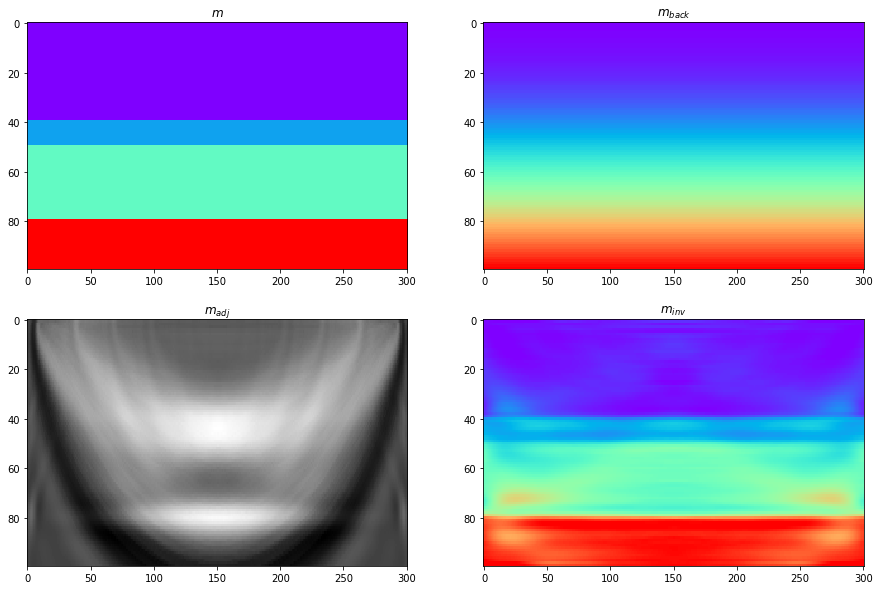

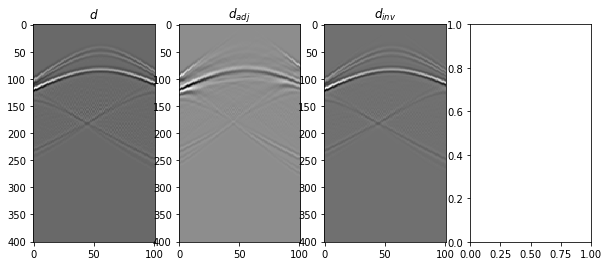

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0][0].imshow(vel.T, cmap='rainbow', vmin=v0, vmax=vel.max())
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(velback.T, cmap='rainbow', vmin=v0, vmax=vel.max())
axs[0][1].set_title(r'$m_{back}$')
axs[0][1].axis('tight')
axs[1][0].imshow(madj.T, cmap='gray')
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{adj}$');
axs[1][1].imshow(minv.T, cmap='rainbow', vmin=v0, vmax=vel.max())
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{inv}$');

fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].imshow(d[ns//2, :, :500].T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(dadj[ns//2, :, :500].T, cmap='gray')
axs[1].set_title(r'$d_{adj}$')
axs[1].axis('tight')
axs[2].imshow(dinv[ns//2, :, :500].T, cmap='gray')
axs[2].set_title(r'$d_{inv}$')
axs[2].axis('tight');

## Marmousi model

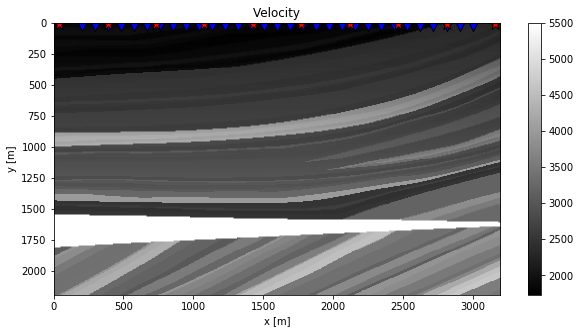

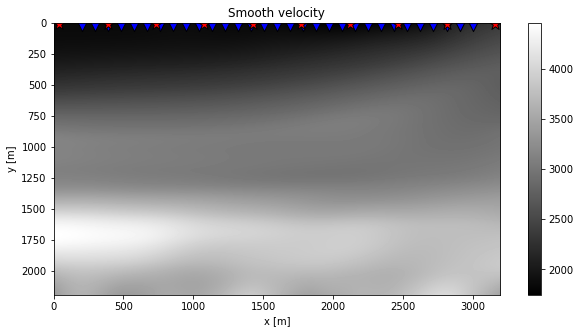

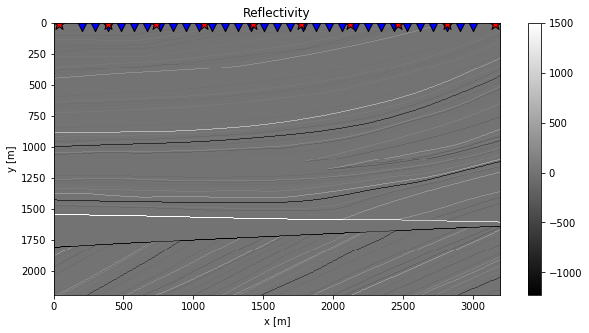

In [14]:
#Velocity
inputfile='../../pylops/testdata/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, vel_true = model['x'] - model['x'][0], model['z'] - model['z'][0], 1000*model['model'].T
nx, nz = len(x), len(z)

# Reflectivity
refl = np.diff(vel_true, axis=1)
refl = np.hstack([refl, np.zeros((nx, 1))])

# Smooth velocity
nsmooth=100
vel = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_true, axis=0)
vel = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel, axis=1)

# Receivers
nr = 31
rx = np.linspace(dx*50, (nx-50)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 10
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel_true.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Smooth velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.ylim(z[-1], z[0]);

Compute traveltimes with eikonal

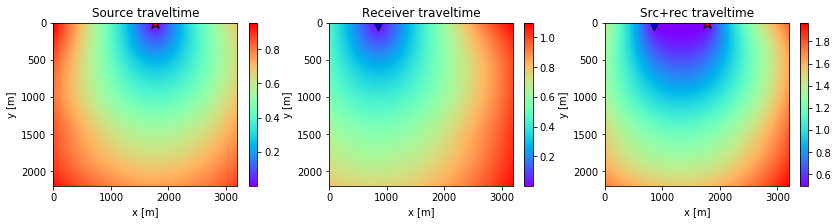

In [15]:
trav, trav_srcs, trav_recs = _traveltime_table(z, x, sources, recs, vel, mode='eikonal')   

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
im = axs[0].imshow(trav_srcs[:, ns//2].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(trav_recs[:, nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_ylabel('y [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(trav[:, ns//2*nr+nr//4].reshape((nx, nz)).T, cmap='rainbow', 
                   extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(sources[0, ns//2], sources[1, ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(recs[0, nr//4], recs[1, nr//4], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_ylabel('y [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0])
plt.colorbar(im, ax=axs[2]);

Create data and invert model

In [16]:
nt = 751
dt = 0.004
t = np.arange(nt)*dt

itrav = (np.round(trav/dt)).astype(np.int32)
travd = trav - itrav
itrav = itrav.reshape(nx, nz, ns*nr)
travd = travd.reshape(nx, nz, ns*nr)

Sop = Spread(dims=(nx, nz), dimsd=(ns*nr, nt), table=itrav, dtable=travd, engine='numba')
dottest(Sop, ns*nr*nt, nx*nz)

wav, wavt, wavc = ricker(t[:41], f0=20)
Cop = Convolve1D(ns*nr*nt, h=wav, offset=wavc, dims=(ns*nr, nt), dir=1)

LSMop = Cop*Sop
LSMop = LinearOperator(LSMop, explicit=False)

d = LSMop * refl.ravel()
d = d.reshape(ns, nr, nt)

madj = LSMop.H * d.ravel()
madj = madj.reshape(nx, nz)

minv = LSMop.div(d.ravel(), niter=100)
minv = minv.reshape(nx, nz)

# demigration
dadj = LSMop * madj.ravel()
dadj = dadj.reshape(ns, nr, nt)

dinv = LSMop * minv.ravel()
dinv = dinv.reshape(ns, nr, nt)

In [17]:
lsm = LSM(z, x, t, sources, recs, vel, wav, wavc,
          mode='eikonal')
d = lsm.Demop * refl.ravel()
d = d.reshape(ns, nr, nt)

madj = lsm.Demop.H * d.ravel()
madj = madj.reshape(nx, nz)

minv = lsm.solve(d.ravel(), solver=lsqr, **dict(iter_lim=100, show=True))
minv = minv.reshape(nx, nz)

minv_sparse = lsm.solve(d.ravel(), solver=FISTA, **dict(eps=1e8, niter=100, show=True))
minv_sparse = minv_sparse.reshape(nx, nz)

# demigration
dadj = LSMop * madj.ravel()
dadj = dadj.reshape(ns, nr, nt)

dinv = LSMop * minv.ravel()
dinv = dinv.reshape(ns, nr, nt)

dinv_sparse = LSMop * minv_sparse.ravel()
dinv_sparse = dinv_sparse.reshape(ns, nr, nt)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has   232810 rows  and   440000 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.604e+09  2.604e+09    1.0e+00  4.1e-05
     1 -1.31431e+00   2.119e+09  2.119e+09    8.1e-01  6.0e-01   1.8e+05  1.0e+00
     2 -1.14798e+01   1.389e+09  1.389e+09    5.3e-01  3.1e-01   2.8e+05  2.9e+00
     3 -1.89388e+01   1.058e+09  1.058e+09    4.1e-01  2.3e-01   3.2e+05  4.4e+00
     4 -1.76684e+01   8.627e+08  8.627e+08    3.3e-01  2.0e-01   3.6e+05  6.1e+00
     5 -1.47031e+01   7.087e+08  7.087e+08    2.7e-01  1.5e-01   3.9e+05  8.0e+00
     6 -1.33344e+01   5.833e+08  5.833e+08    2.2e-01  1.2e-01   4.1e+05  1.0e+01
     7 -1.05971e+01   4.844e+08  4.844e+08    1.9e-01  1.1e-01   4.3e+05  1.2e+01
     8 -7.48001e+00   4.144e

(-0.5, 30.5, 499.5, -0.5)

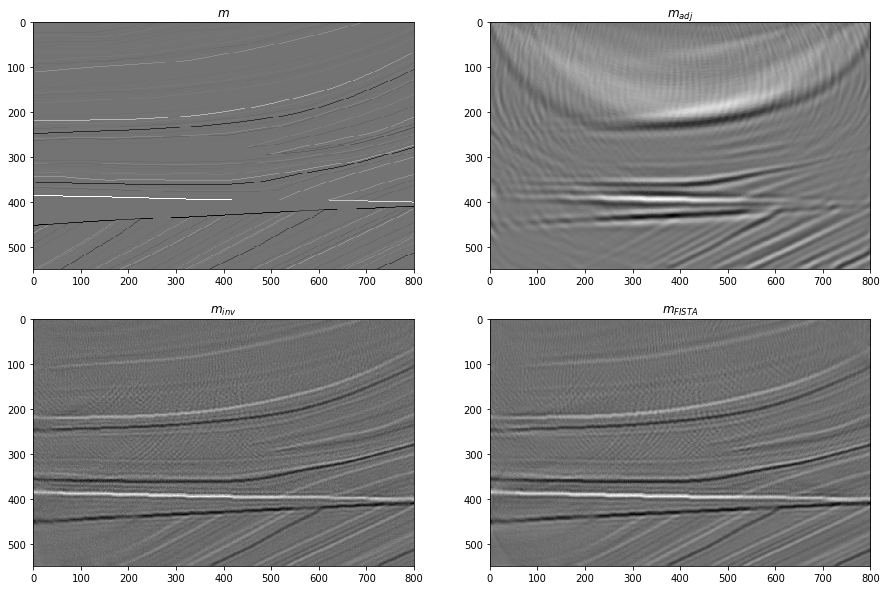

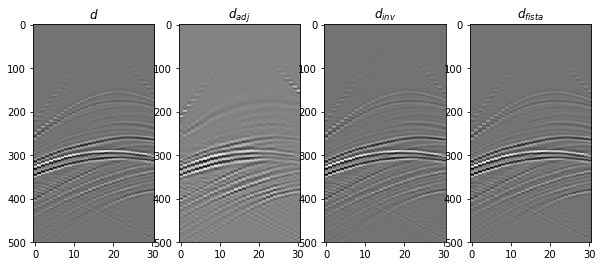

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0][0].imshow(refl.T, cmap='gray')
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(madj.T, cmap='gray')
axs[0][1].set_title(r'$m_{adj}$')
axs[0][1].axis('tight')
axs[1][0].imshow(minv.T, cmap='gray')
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{inv}$');
axs[1][1].imshow(minv_sparse.T, cmap='gray')
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{FISTA}$');

fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].imshow(d[ns//2, :, :500].T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(dadj[ns//2, :, :500].T, cmap='gray')
axs[1].set_title(r'$d_{adj}$')
axs[1].axis('tight')
axs[2].imshow(dinv[ns//2, :, :500].T, cmap='gray')
axs[2].set_title(r'$d_{inv}$')
axs[2].axis('tight');
axs[3].imshow(dinv_sparse[ns//2, :, :500].T, cmap='gray')
axs[3].set_title(r'$d_{fista}$')
axs[3].axis('tight')

Finally let's again invert for the model itself

In [48]:
trav, trav_srcs, trav_recs = _traveltime_table(z, x, sources, recs, vel, mode='eikonal')

itrav = (np.round(trav/dt)).astype(np.int32)
travd = trav - itrav
itrav = itrav.reshape(nx, nz, ns*nr)
travd = travd.reshape(nx, nz, ns*nr)

# Modelling
Sop = Spread(dims=(nx, nz), dimsd=(ns*nr, nt), table=itrav, dtable=travd, engine='numba')
dottest(Sop, ns*nr*nt, nx*nz, verb=True)

wav, wavt, wavc = ricker(t[:41], f0=20)
Cop = Convolve1D(ns*nr*nt, h=wav, offset=wavc, dims=(ns*nr, nt), dir=1)
Dop = FirstDerivative(nx*nz, dims=(nx, nz), dir=1)
LSMop = Cop*Sop*Dop
LSMop = LinearOperator(LSMop, explicit=False)

d = LSMop * np.log(vel_true).ravel()
d = d.reshape(ns, nr, nt)
dback = LSMop * np.log(vel).ravel()
dback = dback.reshape(ns, nr, nt)

madj = (Cop*Sop).H * d.ravel()
madj = madj.reshape(nx, nz)

# Regularized inversion
Regop = SecondDerivative(nx*nz, (nx, nz), dir=0)
minv = RegularizedInversion(LSMop, [Regop], d.ravel(),
                            x0=np.log(vel).ravel(),
                            epsRs=[1e4], returninfo=False,
                            **dict(iter_lim=200, show=True))
minv = np.exp(minv.reshape((nx, nz)))

# demigration
dadj = (Cop*Sop) * madj.ravel()
dadj = dadj.reshape(ns, nr, nt)

dinv = LSMop *  np.log(minv).ravel()
dinv = dinv.reshape(ns, nr, nt)

Dot test passed, v^T(Opu)=12043872.116696 - u^T(Op^Tv)=12043872.116696
 
LSQR            Least-squares solution of  Ax = b
The matrix A has   672810 rows  and   440000 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      200
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.872e+05  6.872e+05    1.0e+00  2.7e-02
     1  2.19072e-02   4.235e+05  4.235e+05    6.2e-01  7.1e-01   2.4e+04  1.0e+00
     2  4.11536e-02   3.322e+05  3.322e+05    4.8e-01  3.7e-01   3.8e+04  2.3e+00
     3  5.61917e-02   2.643e+05  2.643e+05    3.8e-01  2.8e-01   4.8e+04  3.9e+00
     4  6.66096e-02   2.195e+05  2.195e+05    3.2e-01  2.1e-01   5.7e+04  5.6e+00
     5  8.16419e-02   1.899e+05  1.899e+05    2.8e-01  1.9e-01   6.4e+04  7.4e+00
     6  8.69474e-02   1.683e+05  1.683e+05    2.4e-01  1.5e-01   7.2e+04  9.4e+00
     7  8.28600e-02   1.505e+05  1.505e

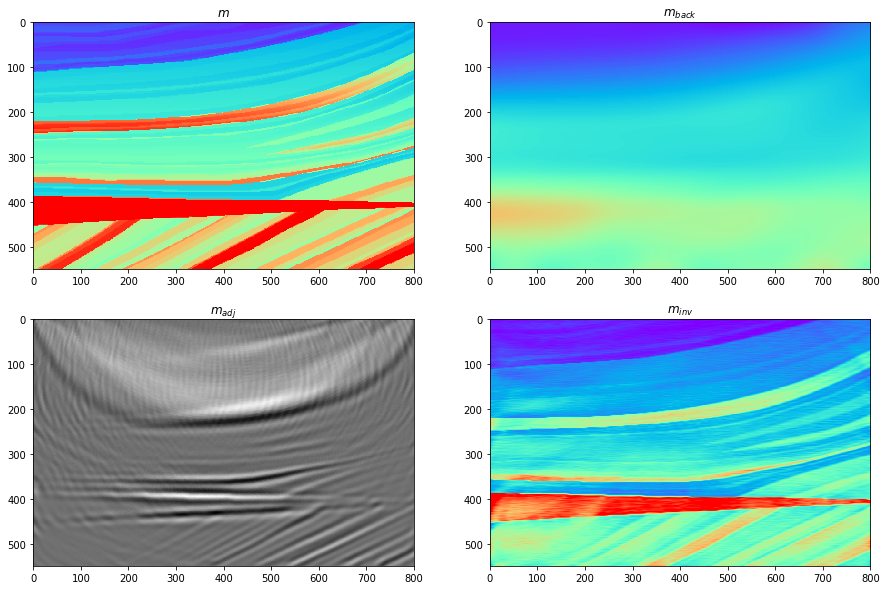

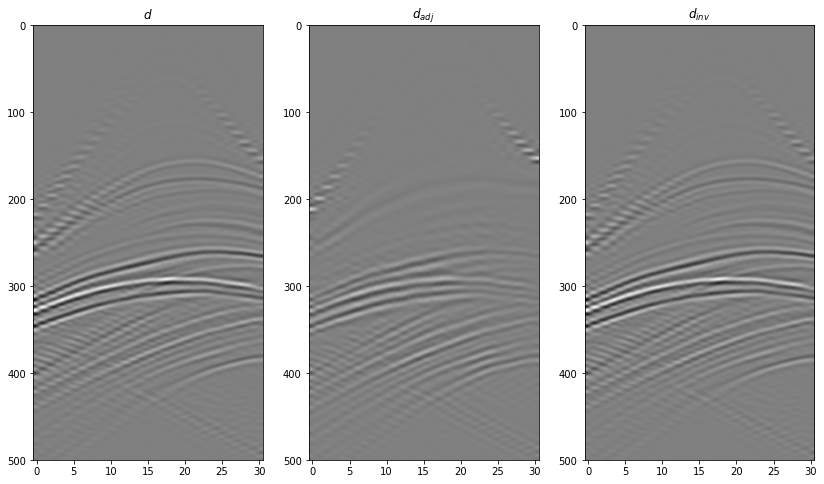

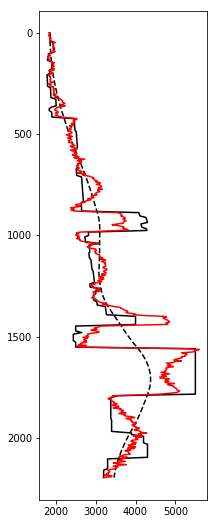

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0][0].imshow(vel_true.T, cmap='rainbow', vmin=v0, vmax=vel.max())
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(vel.T, cmap='rainbow', vmin=vel_true.min(), vmax=vel_true.max())
axs[0][1].set_title(r'$m_{back}$')
axs[0][1].axis('tight')
axs[1][0].imshow(madj.T, cmap='gray')
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{adj}$');
axs[1][1].imshow(minv.T, cmap='rainbow', vmin=vel_true.min(), vmax=vel_true.max())
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{inv}$');

fig, axs = plt.subplots(1, 3, figsize=(14, 8))
axs[0].imshow(d[ns//2, :, :500].T, cmap='gray', interpolation='sinc',
              vmin=-0.5*d.max(), vmax=0.5*d.max())
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(dadj[ns//2, :, :500].T, cmap='gray', interpolation='sinc',
              vmin=-0.1*dadj.max(), vmax=0.1*dadj.max())
axs[1].set_title(r'$d_{adj}$')
axs[1].axis('tight')
axs[2].imshow(dinv[ns//2, :, :500].T, cmap='gray', interpolation='sinc',
              vmin=-0.5*d.max(), vmax=0.5*d.max())
axs[2].set_title(r'$d_{inv}$')
axs[2].axis('tight');

plt.figure(figsize=(3, 9))
plt.plot(vel_true[100], z, 'k')
plt.plot(vel[100], z, '--k')
plt.plot(minv[100], z, 'r')
plt.gca().invert_yaxis()

So far so good but there is much more here to explore:

- First of all we all know that waves do not propagate vertically, so the derivative operator from medium properties to reflectivity should be done normal to the propagation. We could track propagation angles using the wavefront of the traveltime map and use that also to reduce the pairs of sources and receivers to only available ones.

- Along these lines, we could couple localized AVO modelling with the ray-based demigration process and estimate elastic properties even if using only P-waves for the modelling.